In [1]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier






TrainDataFrame = pd.read_csv("data/train.csv")
TestDataFrame = pd.read_csv("data/test.csv")

train_df = copy.deepcopy(TrainDataFrame)
test_df = copy.deepcopy(TestDataFrame)

# Separating out the target category.

y = train_df["Survived"]
train_df = train_df.drop("Survived", axis = 1)

# We drop the "PassengerId" column.

train_df.drop(["PassengerId"], axis = 1, inplace = True)
test_df.drop(["PassengerId"], axis = 1, inplace = True)



# We note that "Age" has a few missing values, "Cabin" has almost all the values missing.
# We delete the "Ticket" and "Cabin" features.

train_df = train_df.drop(["Ticket", "Cabin"], axis = 1)
test_df = test_df.drop(["Ticket", "Cabin"], axis = 1)

# Embarked also has a missing value.

train_df["Embarked"] = train_df["Embarked"].fillna(value = 'S')

# We want to create a category called "Title" which derives only the title from the name.

train_df["Title"] = train_df["Name"].str.split().apply(lambda x: [s for s in x if "." in s][0])
test_df["Title"] = test_df["Name"].str.split().apply(lambda x: [s for s in x if "." in s][0])

train_df = train_df.drop("Name", axis = 1)
test_df = test_df.drop("Name", axis = 1)

# We note that "Title" has many rare titles. We map these to more commonly used titles.

mapping = {'Dr.':'Mr.','Rev.':'Mr.','Mlle.':'Miss.','Major.':'Mr.','Col.':'Mr.','Sir.':'Mr.','Don.':'Mr.','Mme.':'Miss.','Jonkheer.':'Mr.','Lady.':'Mrs.','Capt.':'Mr.','Countess.':'Mrs.','Ms.':'Miss.','Dona.':'Mrs.'}
train_df.replace({'Title':mapping}, inplace = True)
test_df.replace({'Title':mapping}, inplace = True)

# We will use "Title" to impute missing values in "Age".

[ageMaster, ageMiss, ageMr, ageMrs] = train_df.groupby(['Title'])['Age'].mean()

train_df.loc[(train_df['Title'] == 'Master.') & np.isnan(train_df['Age']),'Age'] = ageMaster
train_df.loc[(train_df['Title'] == 'Miss.') & np.isnan(train_df['Age']),'Age'] = ageMiss
train_df.loc[(train_df['Title'] == 'Mr.') & np.isnan(train_df['Age']),'Age'] = ageMr
train_df.loc[(train_df['Title'] == 'Mrs.') & np.isnan(train_df['Age']),'Age'] = ageMrs

test_df.loc[(test_df['Title'] == 'Master.') & np.isnan(test_df['Age']),'Age'] = ageMaster
test_df.loc[(test_df['Title'] == 'Miss.') & np.isnan(test_df['Age']),'Age'] = ageMiss
test_df.loc[(test_df['Title'] == 'Mr.') & np.isnan(test_df['Age']),'Age'] = ageMr
test_df.loc[(test_df['Title'] == 'Mrs.') & np.isnan(test_df['Age']),'Age'] = ageMrs

# The test set has a missing value in "Fare". We fill this with the mean value.
# We also allocate the different values in "Fare" to bins.

test_df.loc[152,"Fare"] = np.nanmean(np.array(test_df["Fare"]))

kbins = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'quantile')
train_df["Fare"] = kbins.fit_transform(np.array(train_df["Fare"]).reshape(-1,1)).astype(int)
test_df["Fare"] = kbins.transform(np.array(test_df["Fare"]).reshape(-1,1)).astype(int)

# We will divide "Age" in bins as well.

kbins = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'quantile')
train_df["AgeBin"] = kbins.fit_transform(np.array(train_df["Age"]).reshape(-1,1)).astype(int)
test_df["AgeBin"] = kbins.transform(np.array(test_df["Age"]).reshape(-1,1)).astype(int)

train_df.drop(["Age"], axis = 1, inplace = True)
test_df.drop(["Age"], axis = 1, inplace = True)


# Let us add some features. We will add a feature that contains the size of your Family.

train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"]
train_df = train_df.drop(["SibSp", "Parch"], axis = 1)

test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"]
test_df = test_df.drop(["SibSp", "Parch"], axis = 1)

# Also whether someone is travelling alone or not.

train_df["TravellingAlone"] = [1 if x == 0 else 0 for x in train_df["FamilySize"]]
test_df["TravellingAlone"] = [1 if x == 0 else 0 for x in test_df["FamilySize"]]


# We need to encode the categorical columns. We will do this by One Hot Encoding.

categorical_columns = train_df.columns[train_df.dtypes == 'object']
numerical_columns = train_df.columns[train_df.dtypes != 'object']

train_df_select = pd.DataFrame(train_df[numerical_columns])
test_df_select = pd.DataFrame(test_df[numerical_columns])

# We add polynomial features.

poly_ftrs = PolynomialFeatures(degree = 3, interaction_only = True, include_bias=False)

train_df_select = pd.DataFrame(poly_ftrs.fit_transform(train_df_select),
                               columns = poly_ftrs.get_feature_names_out(train_df_select.columns)
                              )
test_df_select = pd.DataFrame(poly_ftrs.transform(test_df_select),
                               columns = poly_ftrs.get_feature_names_out(test_df_select.columns)
                             )

# We add categorical features.

train_df_select = train_df_select.join(pd.get_dummies(train_df[categorical_columns]))
test_df_select = test_df_select.join(pd.get_dummies(test_df[categorical_columns]))



# We scale.

std_scl = StandardScaler()

train_df_select_scaled = std_scl.fit_transform(train_df_select)
test_df_select_scaled = std_scl.transform(test_df_select)

In [2]:
# We try out a few models before choosing one of them.

dfs = []

models = [
    ('LogReg', LogisticRegression()), 
    ('RF', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()), 
    ('GNB', GaussianNB()),
    ('GrBstClf', GradientBoostingClassifier()),
    ('AdaBst', AdaBoostClassifier())
]

results = []
scoring = ['accuracy', 'roc_auc']
no_fold = 10
cv_fold = StratifiedKFold(n_splits = no_fold, shuffle = True)

for name, model in models:
        cv_results = cross_validate(model, train_df_select_scaled, y, cv=cv_fold, scoring=scoring)
        results.append(cv_results)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        
        dfs.append(this_df)
        
        final = pd.concat(dfs, ignore_index=True)

final.groupby(['model']).agg([np.mean, np.std]).sort_values(('test_accuracy', 'mean'),ascending = False)

fit_time           score_time           test_accuracy            \
              mean       std       mean       std          mean       std   
model                                                                       
GrBstClf  0.134600  0.000518   0.001782  0.000037      0.829351  0.033213   
SVM       0.019391  0.008316   0.005346  0.002150      0.827116  0.035397   
LogReg    0.039516  0.031830   0.002238  0.000142      0.823733  0.036937   
AdaBst    0.070362  0.005693   0.012615  0.000288      0.816017  0.056934   
RF        0.135800  0.016475   0.020374  0.006387      0.811398  0.048936   
KNN       0.001141  0.000170   0.010382  0.000331      0.805843  0.028488   
GNB       0.000958  0.000025   0.001353  0.000027      0.792297  0.051094   

         test_roc_auc            
                 mean       std  
model                            
GrBstClf     0.881038  0.037121  
SVM          0.851368  0.056139  
LogReg       0.876538  0.032738  
AdaBst       0.882342  0.053477  
RF           0.848344  0.049012  
KNN          0.848427  0.023182  
GNB          0.863749  0.041108

0.837278401997503


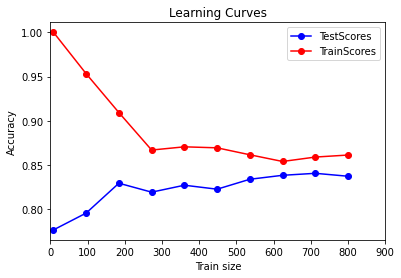

<Figure size 16000x16000 with 0 Axes>

In [3]:
# Let us print cross-validation scores and learning curves for the best model found above.

clf = GradientBoostingClassifier(learning_rate = 0.03)

no_fold = 10
cv_fold = StratifiedKFold(n_splits = no_fold, shuffle = True)

train_sizes = np.linspace(0.01, 1, num = 10)
train_sizes_abs, train_scores, test_scores = learning_curve(
    clf,
    train_df_select_scaled,
    y,
    train_sizes = train_sizes,
    scoring = "accuracy",
    cv = cv_fold
)

plt.plot(
    train_sizes_abs,
    test_scores.mean(1),
    "o-",
    color = "b",
    label = "TestScores"
)
plt.plot(
    train_sizes_abs,
    train_scores.mean(1),
    "o-",
    color = "r",
    label = "TrainScores"
)
plt.xlabel("Train size")
plt.xlim((0, 900))
plt.ylabel("Accuracy")
plt.title("Learning Curves")
plt.legend()

plt.figure(figsize = (20, 20), dpi = 800)

print(test_scores.mean(1)[len(test_scores)-1])

plt.show()

In [4]:
clf.fit(train_df_select_scaled, y)
y_test_predict = clf.predict(test_df_select_scaled)

export = pd.DataFrame(range(892,1310), columns = ["PassengerId"])
export["Survived"] = y_test_predict

export.to_csv('TitanicSolution.csv', index = False)